# Software Effort Estimation Using LLMs

This research work aims to check and evaluate the performance of GPT-4 and LLAMA-3 towards software effort estimation in a zero shot setting and a trained setting.

# Data Exploration

In [86]:
# install libraries
!pip3 install pandas
!pip3 install numpy
!pip3 install matplotlib
!pip3 install wordcloud
!pip3 install seaborn
!pip3 install nltk
!pip3 install mysql-connector-python
!pip3 install transformers
!pip3 install torch


In [87]:
!pip3 freeze > requirements.txt

In [88]:
# import libraries
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import transformers
import torch

In [53]:
# Connect to MySQL
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="My-N7w_And.5ecure-P@s5w0rd",
    database="local"
)

In [54]:
# Read table into DataFrame
query = "SELECT * FROM Issue"
df = pd.read_sql(query, conn)

/tmp/ipykernel_6019/1919074633.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [55]:
# Close connection
conn.close()

In [56]:
# check shape
df.shape

(458232, 30)

there are about 450000 rows with 30 columns in the dataframe

In [57]:
# display first few rows of the dataframe
print(df.head())

   ID  Jira_ID Issue_Key                                            URL  \
0  65    77638   XD-3768  https://jira.spring.io/rest/api/2/issue/77638   
1  66    77511   XD-3767  https://jira.spring.io/rest/api/2/issue/77511   
2  67    77130   XD-3766  https://jira.spring.io/rest/api/2/issue/77130   
3  68    71950   XD-3765  https://jira.spring.io/rest/api/2/issue/71950   
4  69    71805   XD-3764  https://jira.spring.io/rest/api/2/issue/71805   

                                               Title  \
0     "How do I make a job restartable in spring xd"   
1      "admin config timezone command does not work"   
2  "Module Upload command not pushing jar to all ...   
3                             "Fix stream failover "   
4  "SpringXD Job is still executing even after fo...   

                                         Description  \
0  "The jobs that appear under Executions section...   
1  "Working with Spring-XD version 1.3.2.RELEASE ...   
2  "My project 7 node cluster and in that 2 

In [58]:
# describe the df
df.describe()

,ID,Jira_ID,Creation_Date,Estimation_Date,Resolution_Date,Last_Updated,Story_Point,Timespent,In_Progress_Minutes,Total_Effort_Minutes,Resolution_Time_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Story_Point_Changed_After_Estimation,Creator_ID,Reporter_ID,Assignee_ID,Project_ID,Sprint_ID
count,458232.000000,4.582320e+05,458232,65427,352632,458232,6.542700e+04,10243.000000,4.582320e+05,4.582320e+05,4.582320e+05,458232.000000,458232.0,458232.000000,456641.000000,455736.000000,261831.000000,458232.000000,43475.000000
mean,250427.756628,6.842263e+05,2014-04-25 10:20:30.745779968,2016-10-11 02:50:38.484784384,2015-01-17 07:35:58.695246336,2017-10-16 16:03:56.466746368,4.135718e+02,323.090501,5.238023e+03,2.343935e+04,4.084872e+05,0.141330,0.0,0.020068,120547.190712,120825.496105,133827.102066,24.998507,2711.075791
min,65.000000,1.000000e+04,2002-02-08 04:45:00,2004-07-08 10:38:38,2004-02-12 23:48:28,2002-08-04 02:02:50,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000,68.000000,68.000000,71.000000,1.000000,1.000000
25%,114626.750000,5.834075e+04,2011-10-20 09:26:30.500000,2015-02-03 15:20:59.500000,2012-07-19 12:52:00,2016-07-12 00:30:12.750000128,1.000000e+00,46.000000,0.000000e+00,0.000000e+00,4.000000e+00,0.000000,0.0,0.000000,73529.000000,74305.000000,116063.000000,18.000000,1395.500000
50%,229184.500000,1.471675e+05,2014-09-02 12:20:13,2017-01-19 02:10:51,2015-06-09 08:33:02.500000,2018-11-26 12:21:40,3.000000e+00,120.000000,0.000000e+00,0.000000e+00,1.535700e+04,0.000000,0.0,0.000000,145748.000000,145748.000000,151325.000000,23.000000,2941.000000
75%,394473.250000,6.167282e+05,2017-07-22 19:51:16.249999872,2018-09-10 22:02:46.500000,2018-03-27 11:24:24.249999872,2019-09-19 06:46:56,5.000000e+00,300.000000,0.000000e+00,1.458000e+03,2.634485e+05,0.000000,0.0,0.000000,164408.000000,164408.000000,166050.000000,34.000000,4053.000000
max,509035.000000,1.333610e+07,2020-10-23 22:13:07,2020-10-22 14:51:07,2020-10-23 04:53:21,2020-10-24 13:46:06,2.671011e+07,24622.000000,4.771423e+06,4.806555e+06,9.156071e+06,1.000000,0.0,1.000000,209125.000000,209125.000000,208978.000000,44.000000,5027.000000
std,154217.334318,2.121512e+06,NaN,NaN,NaN,NaN,1.044232e+05,761.792096,5.792574e+04,1.286546e+05,8.887023e+05,0.348362,0.0,0.140235,62373.774892,62234.714879,60001.012434,10.805999,1512.380726


In [59]:
# check column names
df.columns

Index(['ID', 'Jira_ID', 'Issue_Key', 'URL', 'Title', 'Description',
       'Description_Text', 'Description_Code', 'Type', 'Priority', 'Status',
       'Resolution', 'Creation_Date', 'Estimation_Date', 'Resolution_Date',
       'Last_Updated', 'Story_Point', 'Timespent', 'In_Progress_Minutes',
       'Total_Effort_Minutes', 'Resolution_Time_Minutes',
       'Title_Changed_After_Estimation',
       'Description_Changed_After_Estimation',
       'Story_Point_Changed_After_Estimation', 'Pull_Request_URL',
       'Creator_ID', 'Reporter_ID', 'Assignee_ID', 'Project_ID', 'Sprint_ID'],
      dtype='object')

In [60]:
# check types
df['Type'].value_counts()

Type
Bug                              215570
Suggestion                        96370
Improvement                       42691
Story                             31394
Task                              28338
Sub-task                          14396
New Feature                       14239
Epic                               4157
Enhancement Request                3239
Support Request                    2368
Build Failure                      1715
Question                           1396
Technical task                      987
Documentation                       699
Test Task                           336
Problem Ticket                      113
Wish                                 88
Milestone                            44
Technical Debt                       30
Investigation                        22
Incident                             18
Test                                 17
Release                               4
Public Security Vulnerability         1
Name: count, dtype: int64

In [61]:
# filter rows with type = 'Story'
df = df[df['Type'] == 'Story']

In [62]:
# check shape
df.shape

(31394, 30)

In [63]:
# extract only useful columns
df = df[['Description','Resolution_Time_Minutes']]

In [64]:
# check shape
df.shape

(31394, 2)

In [65]:
# check few rows
df.sample(10)

,Description,Resolution_Time_Minutes
349353,"""Build path entries are returned as a Set from...",32702.0
243965,"""Create the """"Orchestration and Control"""" slid...",15859.0
241017,"""[~<USER> has discovered that we don't have te...",1855376.0
248541,"""Transition all current S3 objects to use RRS....",139909.0
347655,"""I found out that I can hook up the internal b...",145.0
349675,"""Do the same thing that was done in previous d...",107015.0
241704,"""DM-6258 will produce rough, draft-level diagr...",42534.0
233441,"""Get Puppet running on oradb nodes. Implement ...",45037.0
221783,"""So we've been having a problem where the read...",16.0
232392,"""Please edit with the tickets to be reviewed.""",12804.0


In [66]:
# remove rows with empty descriptions
df = df[df['Description'] != '']

In [67]:
# check shape
df.shape

(27327, 2)

In [68]:
# remove rows with 0 resolution minutes
df = df[df['Resolution_Time_Minutes'] != 0]

In [69]:
# check shape
df.shape

(22459, 2)

In [70]:
# check for null values
df['Description'].isnull().sum()

np.int64(0)

In [71]:
# check for null values
df['Resolution_Time_Minutes'].isnull().sum()

np.int64(0)

In [72]:
# add column for checking length of the descriptions
df['Description_Length'] = df['Description'].apply(lambda x: len(x.split()))

In [73]:
# describe the length column
df['Description_Length'].describe()

count    22459.000000
mean        57.292088
std         97.680646
min          1.000000
25%         19.000000
50%         35.000000
75%         67.000000
max       8374.000000
Name: Description_Length, dtype: float64

the average description length is around 57 characters

In [77]:
# setup ntlk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/udayk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/udayk/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [79]:
# define a function to normalize text
def normalize_text(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    
    # Remove punctuation
    sentence = sentence.translate(str.maketrans("", "", string.punctuation))
    
    # Remove numbers
    sentence = re.sub(r'\d+', '', sentence)
    
    # Remove extra whitespace
    sentence = ' '.join(sentence.split())
    
    # Expand contractions
    contractions = {
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'ve": " have",
        "'m": " am"
    }
    for contraction, expansion in contractions.items():
        sentence = sentence.replace(contraction, expansion)
    
    # # Tokenize the sentence
    words = word_tokenize(sentence)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Perform stemming
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    
    # Join the words back into a sentence
    normalized_sentence = ' '.join(words)
        
    return normalized_sentence

In [80]:
# apply normalize_text function to descriptions and save to new column
df['Cleaned_Description'] = df['Description'].apply(normalize_text)

In [81]:
# check few rows
df['Cleaned_Description'].sample(10)

233043    repres juli work go fixm integr test queri det...
239196    buildtempl script use creat templat file use p...
245173    queri cancel code went dm work fine howev feel...
232505    order begin evalu import variabl psf calcul dc...
227111    concern dmsreq prioriti b nightli data access ...
243269    port httpsconfluencelsstcorporgdisplayldmdgtea...
241       spring xd develop id like move mail modul xd s...
233306    perform check consist creation fit fit file as...
222153             add new packag scipipecondaenv environmn
355874    window unit test sometim crash ticontactsgetal...
Name: Cleaned_Description, dtype: object

In [82]:
# check common words
all_words = ' '.join(df['Cleaned_Description']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(10)
common_words

[('use', 9594),
 ('need', 6245),
 ('code', 5761),
 ('file', 5368),
 ('test', 5192),
 ('user', 4373),
 ('creat', 3672),
 ('data', 3573),
 ('new', 3556),
 ('run', 3537)]

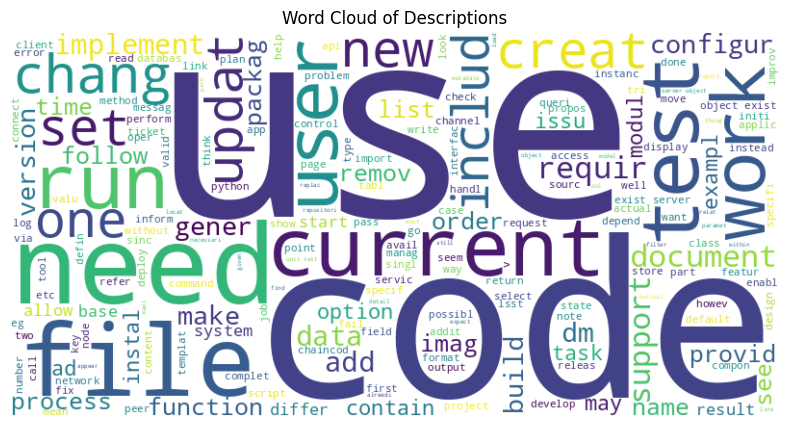

In [83]:
# show word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()

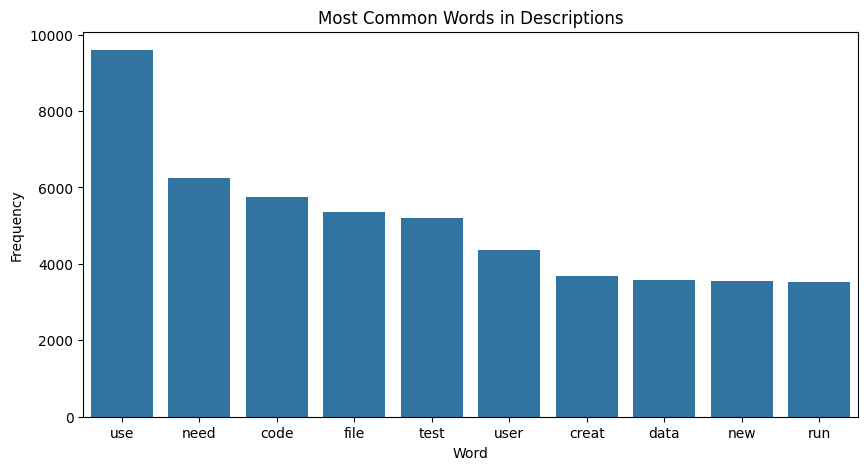

In [84]:
# plot most common words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 5))
sns.barplot(data=common_words_df, x='Word', y='Frequency')
plt.title('Most Common Words in Descriptions')
plt.show()

# LLAMA - 3

In [89]:
# define llama3 model
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

In [90]:
pipeline = transformers.pipeline(
  "text-generation",
  model="meta-llama/Meta-Llama-3-8B-Instruct",
  model_kwargs={"torch_dtype": torch.bfloat16},
  device="cuda",
)

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct.
401 Client Error. (Request ID: Root=1-66908d54-44db862a3b0a142210d403e1;323257dd-883f-4529-8a8e-37f4a750b604)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct/resolve/main/config.json.
Access to model meta-llama/Meta-Llama-3-8B-Instruct is restricted. You must be authenticated to access it.